In [2]:
from statsmodels.graphics.tsaplots import plot_pacf as pacf, plot_acf as acf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data summary
def summary(dtf):
    sumary=pd.concat([dtf.isna().sum(),((dtf == 0).sum())/dtf.shape[0],dtf.dtypes], axis=1)
    sumary=sumary.rename(columns={sumary.columns[0]: 'NaN'})
    sumary=sumary.rename(columns={sumary.columns[1]: 'Zeros'})
    sumary=sumary.rename(columns={sumary.columns[2]: 'Type'})
    sumary['NaN']=sumary['NaN'].astype(str)+' ('+((sumary['NaN']*100/dtf.shape[0]).astype(int)).astype(str)+'%)'
    sumary['Zeros']=(sumary['Zeros']*100).astype(int)
    sumary['Zeros']=(dtf == 0).sum().astype(str)+' ('+sumary['Zeros'].astype(str)+'%)'
    sumary=sumary[['Type','NaN','Zeros']]
    return print(sumary)


In [3]:
df_train = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv")
df_test  = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv")

# last entry of train data is also found in test data, we remove it from the train data to avoid duplicates
df_test=df_test[1:]

# First Glance
Only 4 variables? Cool! 

However, we got 25 wind_speeds which are 0. 
Although it might reasonable but for the sake of our model, we will give them a value later.

In [4]:
summary(df_train)
df_train.head()

                 Type     NaN    Zeros
date           object  0 (0%)   0 (0%)
meantemp      float64  0 (0%)   0 (0%)
humidity      float64  0 (0%)   0 (0%)
wind_speed    float64  0 (0%)  26 (1%)
meanpressure  float64  0 (0%)   0 (0%)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


# Exploratory Data Analysis (EDA)
We will visualize the distribution of each feature. 
* *meantemp* looks slightly negatively skewed but should be fine.
* *humidity* looks fine, no transformation needed.
* *wind_speed* looks positively skewed but most probably due to a few outliers.
* *meanpressure* just doesn't look right, we have a serious outlier problem on this one!

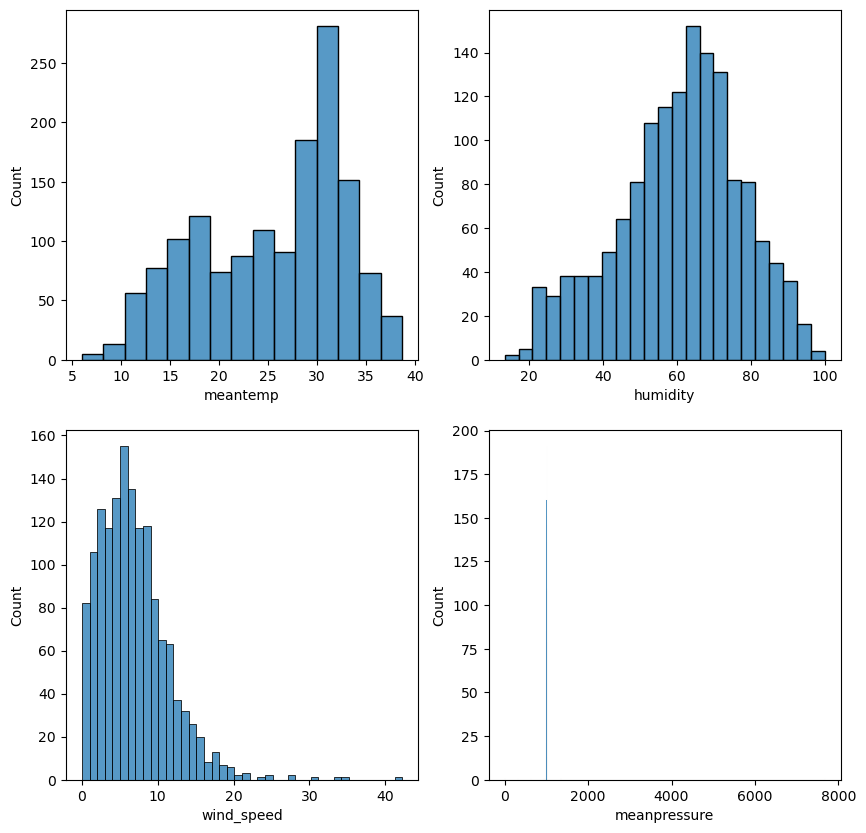

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(data=df_train['meantemp'], ax=axs[0,0])
sns.histplot(data=df_train['humidity'], ax=axs[0,1])
sns.histplot(data=df_train['wind_speed'], ax=axs[1,0])
sns.histplot(data=df_train['meanpressure'], ax=axs[1,1])
plt.show()

# Data Cleansing
From what we saw on *wind_speed* and *meanpressure*, it's time to cleanse these features.

Our assumptions were right, both features are heavily influenced by outliers.

A simple 5% & 95% percentile clipping and cube root transformation will normalize them for good.

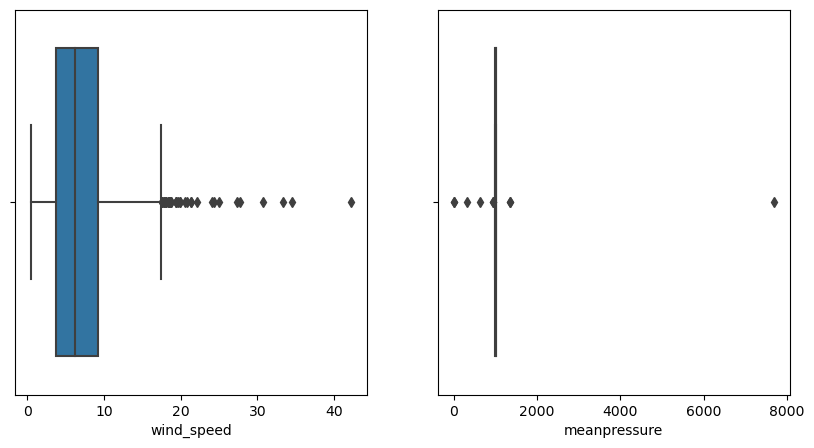

In [6]:
df_train['wind_speed'].replace(0,df_train['wind_speed'].median(), inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(data=df_train, x='meanpressure', ax=axs[1])
sns.boxplot(data=df_train, x='wind_speed', ax=axs[0])
plt.show()

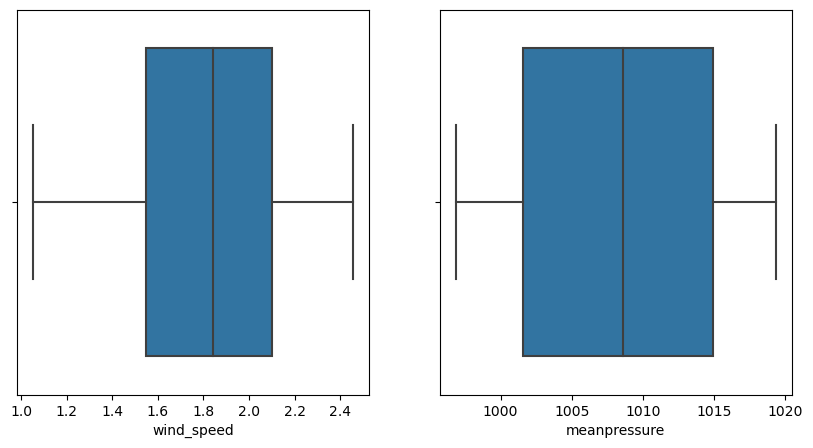

In [7]:
percentiles = df_train['meanpressure'].quantile([0.05, 0.95]).values
df_train['meanpressure']=np.clip(df_train['meanpressure'], percentiles[0], percentiles[1])
df_train['wind_speed']=np.cbrt(df_train['wind_speed'])
percentiles = df_train['wind_speed'].quantile([0.05, 0.95]).values
df_train['wind_speed']=np.clip(df_train['wind_speed'], percentiles[0], percentiles[1])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(x=df_train['meanpressure'], ax=axs[1])
sns.boxplot(x=df_train['wind_speed'], ax=axs[0])
plt.show()

# Seasonal Decomposition of *meantemp*
For ease of visualization, we will downsample the series from Days to Weeks.

Figure(640x480)


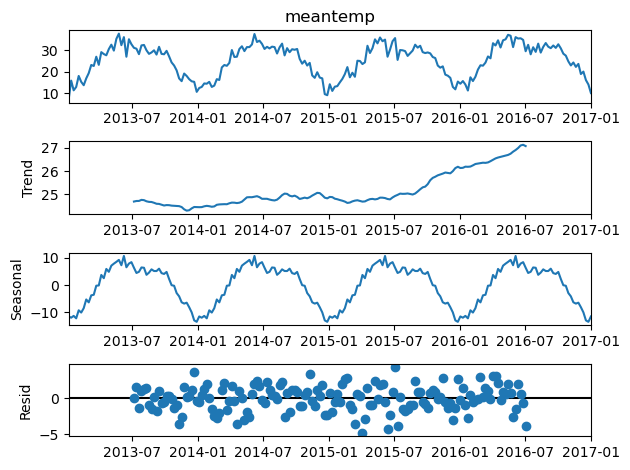

In [8]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.set_index('date').asfreq('W')
print(seasonal_decompose(df_train['meantemp'], model='additive').plot())

Let's look at the different components of *meantemp*.
* Trend - It seems to have an upward trend.
* Seasonal - There's an obvious annual seasonal component.
* Residuals - Looks random which is good

This does not seem to be a stationary series, let's check using **AD Fuller** and **KPSS tests**.

## AD Fuller and KPSS tests on stationarity
Keep in mind that in order to prove that our series is stationary, we have to
* **Reject** null hypothesis in **AD Fuller** test
* **Accept** null hypothesis in **KPSS** Test

In [9]:
adtest=adfuller(df_train['meantemp'][:])
print('ADF Statistic: %f' % adtest[0])
print('p-value: %f' % adtest[1])
print('Critical Values:')
for key, value in adtest[4].items():
 print('\t%s: %.3f' % (key, value))
print("Since p-value < 0.05, we reject the null hypothesis, therefore the series is STATIONARY. \n" if adtest[1] < 0.05 else "Since p-value > 0.05, we fail to reject the null hypothesis, the series is NOT STATIONARY. \n")

kptest=kpss(df_train['meantemp'][:])
print('KPSS Statistic: %f' % kptest[0])
print('p-value: %f' % kptest[1])
print('Critical Values:')
for key, value in kptest[3].items():
 print('\t%s: %.3f' % (key, value))
print("Since p-value < 0.05, we reject the null hypothesis and the series is NOT STATIONARY. \n" if kptest[1] < 0.05 else "Since p-value > 0.05, we fail to reject the null hypothesis, therefore the series is STATIONARY. \n")

ADF Statistic: -4.428957
p-value: 0.000264
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Since p-value < 0.05, we reject the null hypothesis, therefore the series is STATIONARY. 

KPSS Statistic: 0.076783
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Since p-value > 0.05, we fail to reject the null hypothesis, therefore the series is STATIONARY. 



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Contrary to our belief, it passed both stationarity tests even without differencing. So we may proceed to the next step with out stationary series.

# BONUS: Differencing of series
Although the original series is already stationary, we will see if the 1st order of differencing makes it better.

Figure(640x480)


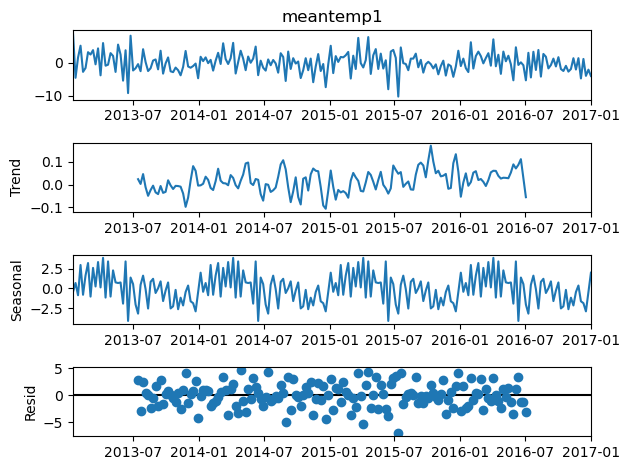

In [10]:
df_train['meantemp1']=df_train['meantemp'].diff(periods=1)
print(seasonal_decompose(df_train['meantemp1'][1:], model='additive').plot())

Now there is definitely no trend, no further differencing required.

Let's run both stationarity tests again on the differenced series:

In [11]:
adtest=adfuller(df_train['meantemp1'][1:])
print('ADF Statistic: %f' % adtest[0])
print('p-value: %f' % adtest[1])
print('Critical Values:')
for key, value in adtest[4].items():
 print('\t%s: %.3f' % (key, value))
print("Since p-value < 0.05, we reject the null hypothesis, therefore the series is STATIONARY. \n" if adtest[1] < 0.05 else "Since p-value > 0.05, we fail to reject the null hypothesis, the series is NOT STATIONARY \n")

kptest=kpss(df_train['meantemp1'][1:])
print('KPSS Statistic: %f' % kptest[0])
print('p-value: %f' % kptest[1])
print('Critical Values:')
for key, value in kptest[3].items():
 print('\t%s: %.3f' % (key, value))
print("Since p-value < 0.05, we reject the null hypothesis and the series is NOT STATIONARY \n" if kptest[1] < 0.05 else "Since p-value > 0.05, we fail to reject the null hypothesis, therefore the series is STATIONARY. \n")

ADF Statistic: -3.366485
p-value: 0.012156
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Since p-value < 0.05, we reject the null hypothesis, therefore the series is STATIONARY. 

KPSS Statistic: 0.246443
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Since p-value > 0.05, we fail to reject the null hypothesis, therefore the series is STATIONARY. 



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Though still stationary, it is insignificant at the 1% level of the ADF test. Therefore, we will proceed with using the undifferenced data first.

## ACF and PACF visualization
It's time to tackle the MA and AR components *p* & *q* with the help of our ACF and PACF plots.

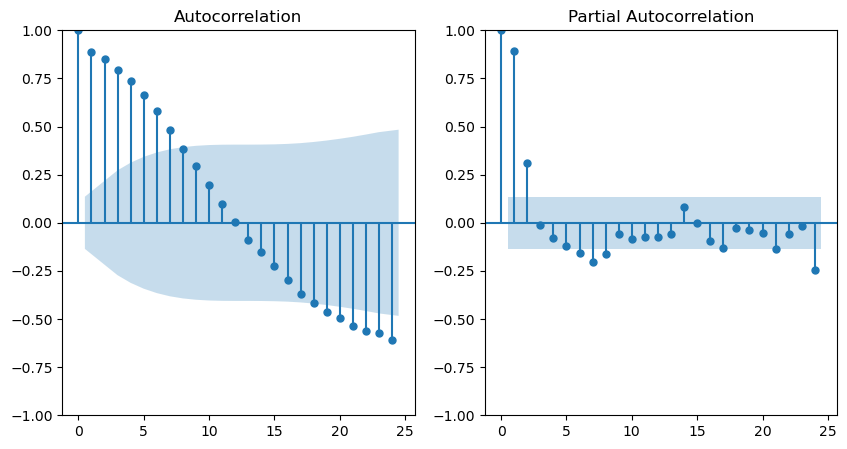

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
acf(df_train['meantemp'][:], ax=ax[0])
pacf(df_train['meantemp'][:], ax=ax[1])
plt.show()

Based on the ACF and PACF plots
* m=52 since it has an annual cycle equivalent to 52 weeks
* ACF : Significant at lag 7 or 8 (*q*=7) 
* PACF: Significant at lag 2 (*p*=2)

However the ACF plot flats out too slowly, probably the differenced series will do better, let us try on the differenced series too:

### ACF and PACF of Differenced Series (d=1)

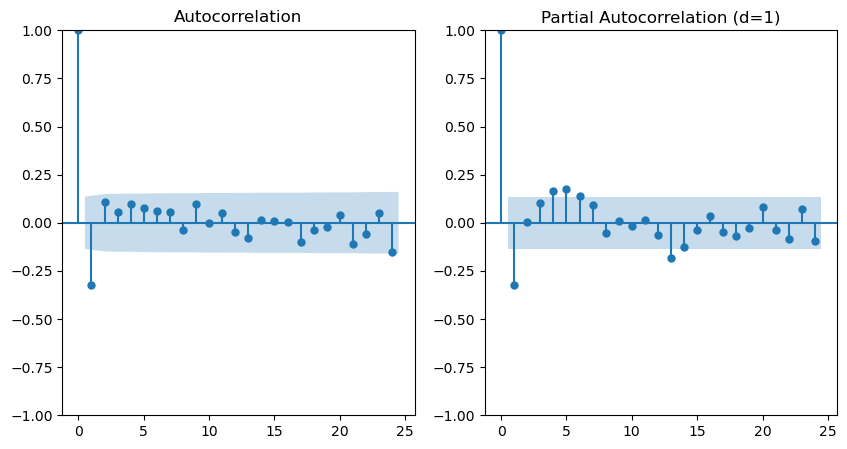

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
acf(df_train['meantemp1'][1:], ax=ax[0])
plt.title('Autocorrelation (d=1)')
pacf(df_train['meantemp1'][1:], ax=ax[1])
plt.title('Partial Autocorrelation (d=1)')
plt.show()

For the differenced series d=1, both ACF and PACF are significant after lag 1, this seems like a better model to be fitted so **we will use this model instead**.

# Model Training & Evaluation

## 1. SARIMA Model
A SARIMA model is necessary in our case due to the obvious annual seasonality. Let's build the SARIMA model using values of p,d,q determined earlier.

In [15]:
sarima_model=SARIMAX(df_train['meantemp'], order=(1,1,1), seasonal_order=(2,1,0,52))
model=sarima_model.fit()
print(model.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89890D+00    |proj g|=  1.03470D-01

At iterate    5    f=  1.81741D+00    |proj g|=  1.04416D-02

At iterate   10    f=  1.81633D+00    |proj g|=  1.49395D-02

At iterate   15    f=  1.81565D+00    |proj g|=  4.79809D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.880D-06   1.816D+00
  F =   1.8156461495368983     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

After thorough trial-and-error, this **SARIMA(1,1,1),(2,1,0,52)** works best with an AIC of 769. 

We should check on the residuals too:

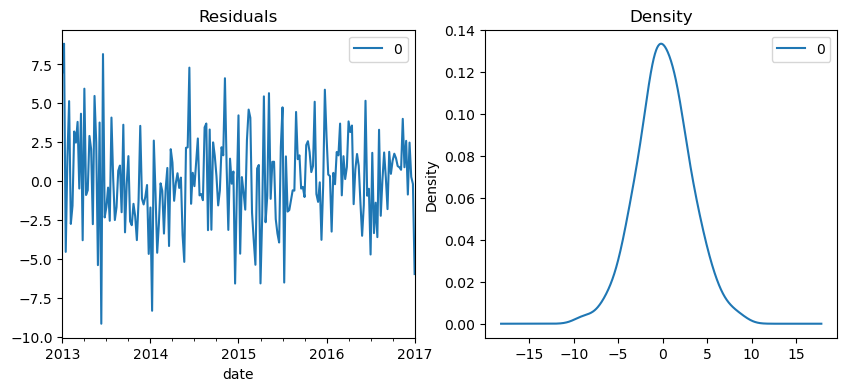

In [16]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2,figsize=(10, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residuals are normally distributed, another tick on our checklist!

Let's visualize the whole model and our training data:

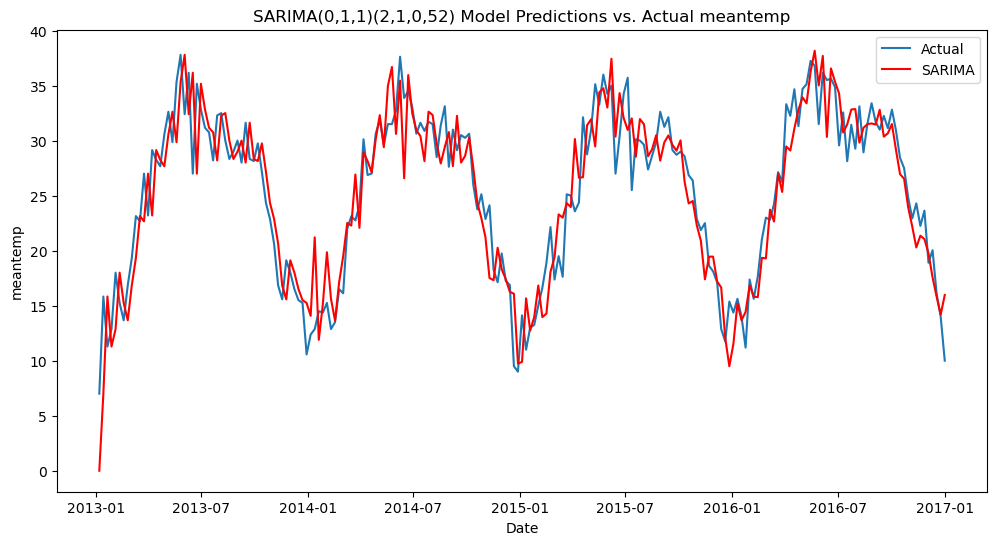

In [19]:
train=model.predict()
plt.figure(figsize=(12, 6))
plt.plot(df_train['meantemp'], label='Actual')
plt.plot(train, color='r', label='SARIMA')
plt.legend()
plt.title('SARIMA(0,1,1)(2,1,0,52) Model Predictions vs. Actual meantemp')
plt.xlabel('Date')
plt.ylabel('meantemp')
plt.show()

This looks like a fairly good fit, but we are more interested in it's prediction accuracy on unseen data. Let's bring out our test data and put this model to the ultimate test! (no pun intended)

## Forecasting using SARIMA
We will now evaluate our model based on the unseen test data, but first the test data has to be converted from Days to Weeks too.

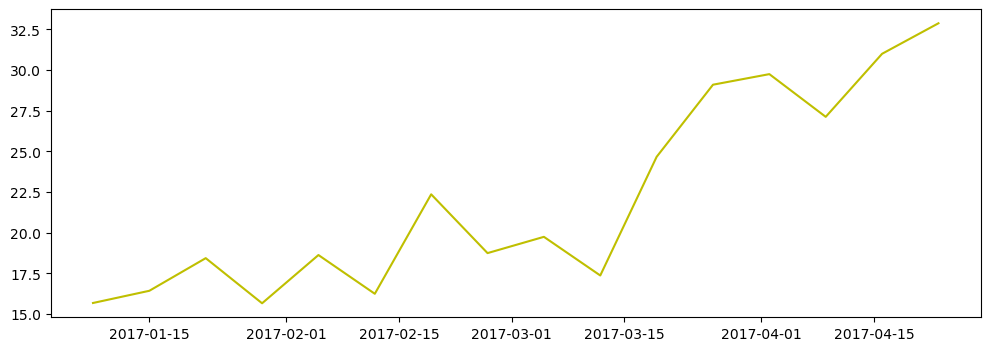

In [20]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.set_index('date').asfreq('W')
plt.figure(figsize=(12, 4))
plt.plot(df_test['meantemp'], color='y',label='Test')
plt.show()

And by using our SARIMA model to forecast, 

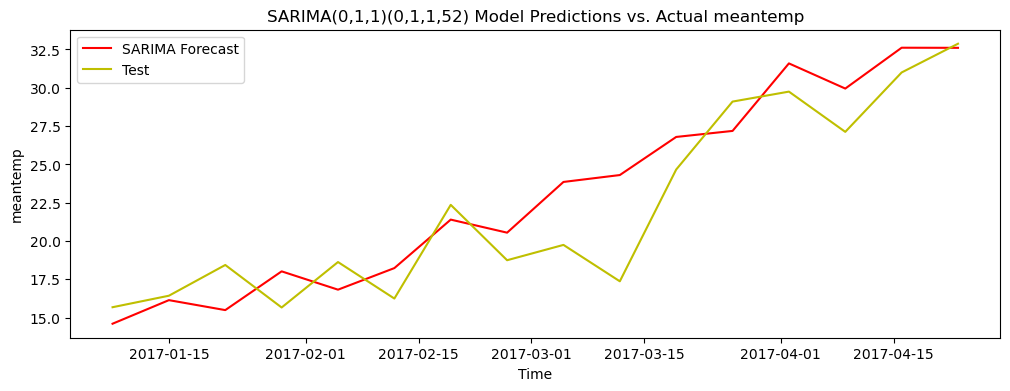

In [21]:
forecast=model.forecast(steps=len(df_test))
plt.figure(figsize=(12, 4))
plt.plot(forecast, color='r', label='SARIMA Forecast')
plt.plot(df_test['meantemp'], color='y', label='Test')
plt.legend()
plt.title('SARIMA(0,1,1)(0,1,1,52) Model Predictions vs. Actual meantemp')
plt.xlabel('Time')
plt.ylabel('meantemp')
plt.show()

At least the trend seems to align, but in terms of accuracy, we'll let our regression metrics (R-squared, MSE, MAE) do the talking:

In [22]:
print("R-squared: "+str(r2_score(df_test['meantemp'], forecast)))
print("MSE: "+str(mean_squared_error(df_test['meantemp'], forecast)))
print("MAE: "+str(mean_absolute_error(df_test['meantemp'], forecast)))

R-squared: 0.7920455848375278
MSE: 7.123741214966365
MAE: 2.1778795484404414


With a R-squared of 79%, this model seems to explain the test data well. Let's see the whole visual:

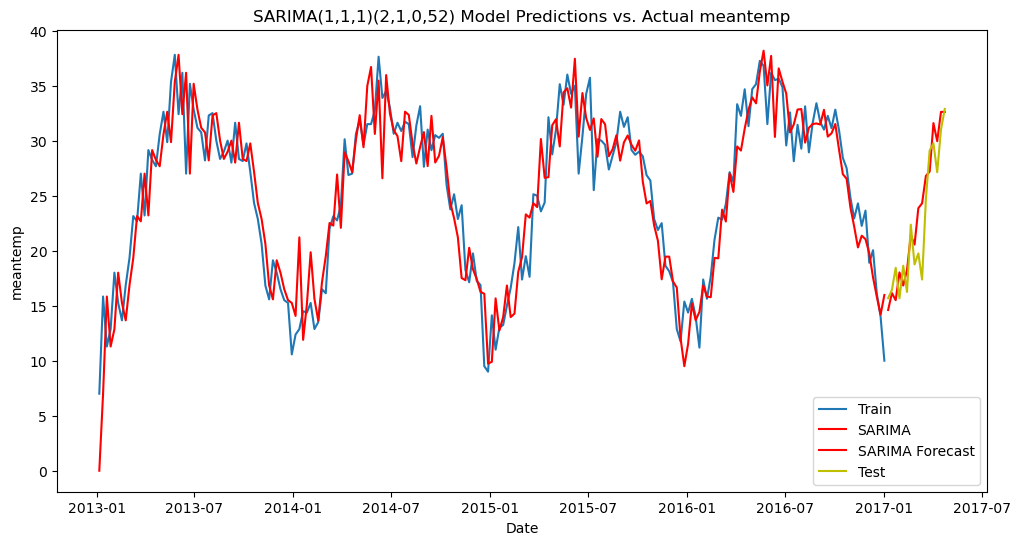

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df_train['meantemp'], label='Train')
plt.plot(train, color='r', label='SARIMA')
plt.plot(forecast, color='r', label='SARIMA Forecast')
plt.plot(df_test['meantemp'], color='y', label='Test')
plt.legend()
plt.title('SARIMA(1,1,1)(2,1,0,52) Model Predictions vs. Actual meantemp')
plt.xlabel('Date')
plt.ylabel('meantemp')
plt.show()

And it seems to fit into the whole picture, another job well done!